# Подключение основных библиотек и загрузка данных


### Для Google Colaboratory

In [ ]:
# Подключение Google Drive к виртуальной машине
from google.colab import drive
drive.mount('/content/drive')

# Копирование данных с Google Drive на локальный диск виртуальной машины.
#!cp -r /content/drive/MyDrive/practice_2022-2023/data/ICBEBnpy/ .
!cp -r /content/drive/MyDrive/practice_2022-2023/data/ptbxlnpy/ .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Подключение пакетов

In [ ]:
# Для работы с данными
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
import tensorflow as tf
import math
import pickle

# Для работы с моделями
from tensorflow import keras
from keras import layers

# Для метрик
from keras import backend as K
from keras.metrics import AUC, Recall, Precision, Accuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

# Код из учебника Жерона 
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)
        
# Загрузка ICBEB
def load_ICBEB(task):
  if task == 'diag':
    X_train = np.load('data_npy/ICBEBnpy/X_train_ICBEB_diag.npy')
    y_train = np.load('data_npy/ICBEBnpy/y_train_ICBEB_diag.npy')
    X_test = np.load('data_npy/ICBEBnpy/X_val_ICBEB_diag.npy')
    y_test = np.load('data_npy/ICBEBnpy/y_val_ICBEB_diag.npy')
  elif task == 'superdiag':
    X_train = np.load('data_npy/ICBEBnpy/X_train_ICBEB_superdiag.npy')
    y_train = np.load('data_npy/ICBEBnpy/y_train_ICBEB_superdiag.npy')
    X_test = np.load('data_npy/ICBEBnpy/X_val_ICBEB_superdiag.npy')
    y_test = np.load('data_npy/ICBEBnpy/y_val_ICBEB_superdiag.npy')
  elif task == 'all':
    X_train = np.load('data_npy/ICBEBnpy/X_train_ICBEB_all.npy')
    y_train = np.load('data_npy/ICBEBnpy/y_train_ICBEB_all.npy')
    X_test = np.load('data_npy/ICBEBnpy/X_val_ICBEB_all.npy')
    y_test = np.load('data_npy/ICBEBnpy/y_val_ICBEB_all.npy')
  elif task == 'subdiag':
    X_train = np.load('data_npy/ICBEBnpy/X_train_ICBEB_subdiag.npy')
    y_train = np.load('data_npy/ICBEBnpy/y_train_ICBEB_subdiag.npy')
    X_test = np.load('data_npy/ICBEBnpy/X_val_ICBEB_subdiag.npy')
    y_test = np.load('data_npy/ICBEBnpy/y_val_ICBEB_subdiag.npy')
  elif task == 'rhythm':
    X_train = np.load('data_npy/ICBEBnpy/X_train_ICBEB_rhythm.npy')
    y_train = np.load('data_npy/ICBEBnpy/y_train_ICBEB_rhythm.npy')
    X_test = np.load('data_npy/ICBEBnpy/X_val_ICBEB_rhythm.npy')
    y_test = np.load('data_npy/ICBEBnpy/y_val_ICBEB_rhythm.npy')
  elif task == 'form':
    X_train = np.load('data_npy/ICBEBnpy/X_train_ICBEB_form.npy')
    y_train = np.load('data_npy/ICBEBnpy/y_train_ICBEB_form.npy')
    X_test = np.load('data_npy/ICBEBnpy/X_val_ICBEB_form.npy')
    y_test = np.load('data_npy/ICBEBnpy/y_val_ICBEB_form.npy')
  #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
  return X_train, y_train, X_test, y_test

# Загрузка ptbxl
def load_ptbxl(task):
  if task == 'diag':
    X_train = np.load('ptbxlnpy/X_train_ptbxl_diag.npy')
    y_train = np.load('ptbxlnpy/y_train_ptbxl_diag.npy')
    X_test = np.load('ptbxlnpy/X_val_ptbxl_diag.npy')
    y_test = np.load('ptbxlnpy/y_val_ptbxl_diag.npy')
  elif task == 'superdiag':
    X_train = np.load('ptbxlnpy/X_train_ptbxl_superdiag.npy')
    y_train = np.load('ptbxlnpy/y_train_ptbxl_superdiag.npy')
    X_test = np.load('ptbxlnpy/X_val_ptbxl_superdiag.npy')
    y_test = np.load('ptbxlnpy/y_val_ptbxl_superdiag.npy')
  elif task == 'all':
    X_train = np.load('ptbxlnpy/X_train_ptbxl_all.npy')
    y_train = np.load('ptbxlnpy/y_train_ptbxl_all.npy')
    X_test = np.load('ptbxlnpy/X_val_ptbxl_all.npy')
    y_test = np.load('ptbxlnpy/y_val_ptbxl_all.npy')
  elif task == 'subdiag':
    X_train = np.load('ptbxlnpy/X_train_ptbxl_subdiag.npy')
    y_train = np.load('ptbxlnpy/y_train_ptbxl_subdiag.npy')
    X_test = np.load('ptbxlnpy/X_val_ptbxl_subdiag.npy')
    y_test = np.load('ptbxlnpy/y_val_ptbxl_subdiag.npy')
  elif task == 'rhythm':
    X_train = np.load('ptbxlnpy/X_train_ptbxl_rhythm.npy')
    y_train = np.load('ptbxlnpy/y_train_ptbxl_rhythm.npy')
    X_test = np.load('ptbxlnpy/X_val_ptbxl_rhythm.npy')
    y_test = np.load('ptbxlnpy/y_val_ptbxl_rhythm.npy')
  elif task == 'form':
    X_train = np.load('ptbxlnpy/X_train_ptbxl_form.npy')
    y_train = np.load('ptbxlnpy/y_train_ptbxl_form.npy')
    X_test = np.load('ptbxlnpy/X_val_ptbxl_form.npy')
    y_test = np.load('ptbxlnpy/y_val_ptbxl_form.npy')
  #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
  return X_train, y_train, X_test, y_test

# Сериализация
def sp(obj, name): # sp = serialization_pickle ;name = *.pkl
    with open(name, 'wb') as pickle_out:
        pickle.dump(obj, pickle_out)

# Компиляция и обучение модели
def AUC_Keras(y_true, y_pred):
    auc = keras.metrics.AUC(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

# Компиляция и обучение модели
def compile_fit(model, X_train, y_train, X_val = None, y_val = None, validation_split = 0.0, batch_size = None, epochs = None, early_stopping = None, model_checkpoint = None, onecycle = None):
  model.compile(loss = keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.experimental.AdamW(),
                metrics=['AUC'])
  
  if X_val == None:
    history = model.fit(X_train, y_train, 
                        epochs = epochs, 
                        batch_size = batch_size,
                        validation_data = None, 
                        validation_split=validation_split, 
                        callbacks=[onecycle, model_checkpoint, early_stopping])
    sp(history, 'history.pkl')
  else:
    history = model.fit(X_train, y_train, 
                        epochs = epochs,
                        batch_size = batch_size, 
                        validation_data = (X_val, y_val), 
                        validation_split=0.0, 
                        callbacks=[onecycle, model_checkpoint, early_stopping])
    sp(history, 'history.pkl')
  return history

# TP TN FP FN
def tp_tn_fp_fn(y_true, y_pred):
  TP = TruePositives()
  TN = TrueNegatives()
  FP = FalsePositives()
  FN = FalseNegatives()
  TP.update_state(y_true, y_pred)
  TN.update_state(y_true, y_pred)
  FP.update_state(y_true, y_pred)
  FN.update_state(y_true, y_pred)
  return TP.result().numpy(),  TN.result().numpy(),  FP.result().numpy(), FN.result().numpy() 

# Подсчет метрик
def calc_metrics(t, p, flag = 0): # t - y_true, p - y_pred
  y_true=np.argmax(t, axis=1)
  y_pred=np.argmax(p, axis=1)
  beta = 2

  f2_score = fbeta_score(y_true, y_pred, average='macro', beta=2)
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  TP, TN, FP, FN = tp_tn_fp_fn(t, p)
  g2_score = TP/(TP+FP+beta*FN)
    
  sp(f2_score, 'f2_score.pkl')
  sp(g2_score, 'g2_score.pkl')
  sp(precision, 'precision.pkl')
  sp(recall, 'recall.pkl')
  sp(TP, 'TP.pkl')
  sp(TN, 'TN.pkl')
  sp(FP, 'FP.pkl')
  sp(FN, 'FN.pkl')
  sp(y_true, 'y_true_argmax.pkl')
  sp(y_pred, 'y_pred_argmax.pkl')
    
  if flag == 0:
    return f2_score, g2_score
  elif flag == 1:
    return f2_score, g2_score, precision, recall

# Таблица результатов
table_res_ptbxl = pd.DataFrame(columns = ('AUC', 'F2', 'G2'))

# Занесение новых результатов в таблицу
def edit_table(table, model, X, y, index_name): # X - X_test, y - y_test 
  score = model.evaluate(X, y)
  y_pr = model.predict(X)
  f2_score, g2_score = calc_metrics(y, y_pr, flag = 0)
  list_metrics = [score[1], f2_score, g2_score] # AUC, F2, G2
  table.loc[index_name] = list_metrics

  sp(score, 'score.pkl')
  sp(y_pr, 'y_pred.pkl')
  sp(y, 'y_test.pkl')
    
  return table

# График loss и accuracy
def plot_loss_and_accuracy_curves(_history):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
  axs[0].plot(_history.history['loss'], color='b', label='Training loss')
  axs[0].plot(_history.history['val_loss'], color='r', label='Validation loss')
  axs[0].set_title("Loss")
  axs[0].legend(loc='best', shadow=True)
  axs[1].plot(_history.history['auc'], color='b', label='Training accuracy')
  axs[1].plot(_history.history['val_auc'], color='r', label='Validation accuracy')
  axs[1].set_title("AUC")
  axs[1].legend(loc='best', shadow=True)
  plt.show()
  
# Работа с моделями lstm и lstm_bidir
def type_comp_fit_save_model_score(table, X_train, y_train, X_test, y_test, type_model, save_name, index_model_task, batch_size, epochs, onecycle):
  # количество классов
  num_classes = y_train.shape[1]
  sp(num_classes, 'num_classes.pkl')

  # Выбор архитектуры модели
  if type_model == 'lstm':
    inputs = keras.Input(shape=(1000, 12))
    x = layers.LSTM(units=256,
                    return_sequences=True,
                    stateful=False,
                    unroll=False)(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.LSTM(units=256,
                    return_sequences=True, # True if concat
                    stateful=False,
                    unroll=False)(x)
    x = layers.LeakyReLU()(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    concat = layers.Concatenate()([avg_pool, max_pool])
    outputs = layers.Dense(units=num_classes, activation='sigmoid')(concat)
    #outputs = layers.Dense(units=num_classes, activation='softmax')(x) # if concat off  
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    
    sp(model, 'model.pkl')
    sp(model.summary(), 'model_summary().pkl')
    
    # Реализация раннего прекращения.
    checkpoint_filepath = './checkpoint_lstm/'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                          save_weights_only=True,
                                                          save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=epochs//10,
                                                  restore_best_weights=True)
  elif type_model == 'lstm_bidir':
    inputs = keras.Input(shape=(1000, 12))
    x = layers.Bidirectional(layers.LSTM(units=256,
                             return_sequences = True,
                             stateful = False,
                             unroll = False))(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Bidirectional(layers.LSTM(units=256,
                             return_sequences = True,
                             stateful = False,
                             unroll = False))(x)
    x = layers.LeakyReLU()(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    concat = layers.Concatenate()([avg_pool, max_pool])
    outputs = layers.Dense(units=num_classes, activation='softmax')(concat)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.build(input_shape = (None, 1000, 12)) # `input_shape` is the shape of the input data
    
    print(model.summary())
    
    sp(model, 'model.pkl')
    sp(model.summary(), 'model_summary().pkl')

    # Реализация раннего прекращения.
    checkpoint_filepath = './checkpoint_lstm_bidir/'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                          save_weights_only=True,
                                                          save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=epochs//10,
                                                  restore_best_weights=True)
  
  # Обучение
  History = compile_fit(model, X_train, y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, early_stopping=early_stopping, model_checkpoint=model_checkpoint, onecycle=onecycle)

  # Сохранение модели
  model.save(save_name)

  # Построение графика
  plot_loss_and_accuracy_curves(History)

  # Сохранение в таблицу
  table = edit_table(table, model, X_test, y_test, index_model_task)

  sp(table, 'table.pkl')
  return table
                        
tf.random.set_seed(42)
%matplotlib inline

# Работа с lstm и lstm_bidir

### lstm

***task = 'all'***

In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'all')
batch_size = 512
epochs = 200
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * epochs, max_rate=0.0001)
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test,type_model = 'lstm', save_name = 'model_lstm_all',index_model_task = 'lstm_all', batch_size=batch_size, epochs=epochs, onecycle=onecycle)
del(X_train)
del(y_train)
del(X_test)
del(y_test)

FileNotFoundError: ignored

***task = 'diag'***

In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'diag')
batch_size = 256
epochs = 100
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * epochs, max_rate=0.0001)
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test,type_model = 'lstm', save_name = 'model_lstm_diag',index_model_task = 'lstm_diag', batch_size=batch_size, epochs=epochs, onecycle=onecycle)
del(X_train)
del(y_train)
del(X_test)
del(y_test)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 1000, 256)    275456      ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 1000, 256)    0           ['lstm_4[0][0]']                 
                                                                                                  
 lstm_5 (LSTM)                  (None, 1000, 256)    525312      ['leaky_re_lu_4[0][0]']          
                                                                                            

In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'superdiag')
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm', 'lstm_superdiag.hdf5', 'lstm_superdiag')
del(X_train)
del(y_train)
del(X_test)
del(y_test)

FileNotFoundError: ignored

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1000, 256)         275456    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1000, 256)         0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 23)                5911      
                                                                 
Total params: 806,679
Trainable params: 806,679
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
542/542 [=======================

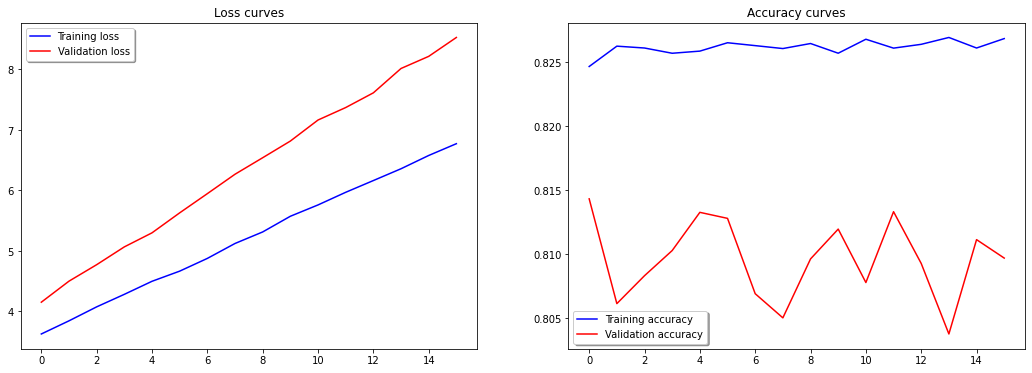

68/68 [==============================] - 3s 40ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'subdiag')
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm', 'lstm_subdiag.hdf5', 'lstm_subdiag')
del(X_train)
del(y_train)
del(X_test)
del(y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1000, 256)         275456    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1000, 256)         0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3084      
                                                                 
Total params: 803,852
Trainable params: 803,852
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
534/534 [=======================

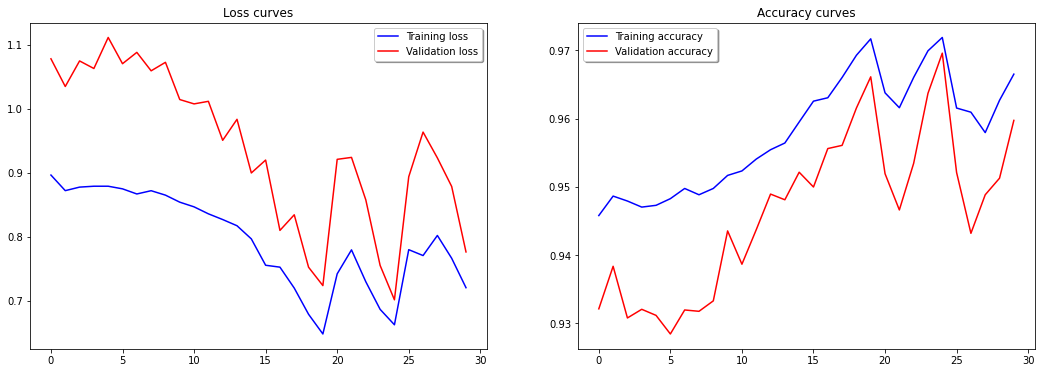

66/66 [==============================] - 3s 41ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'rhythm')
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm', 'lstm_rhythm.hdf5', 'lstm_rhythm')
del(X_train)
del(y_train)
del(X_test)
del(y_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1000, 256)         275456    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1000, 256)         0         
                                                                 
 lstm_9 (LSTM)               (None, 256)               525312    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 19)                4883      
                                                                 
Total params: 805,651
Trainable params: 805,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
228/228 [=======================

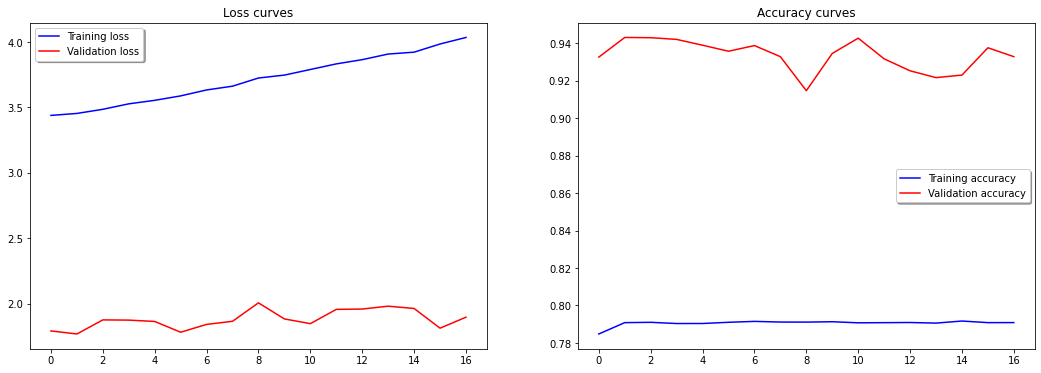

28/28 [==============================] - 2s 39ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'form')
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm', 'lstm_form.hdf5', 'lstm_form')
del(X_train)
del(y_train)
del(X_test)
del(y_test)

### lstm_bidir

***task = 'all'***

In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'all')
batch_size = 32
epochs = 100
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test,type_model = 'lstm_bidir',save_name = 'model_lstm_bidir_all', index_model_task = 'lstm_bidir_all', batch_size=batch_size, epochs=epochs, onecycle=onecycle)
del(X_train)
del(y_train)
del(X_test)
del(y_test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1000, 512)        550912    
 l)                                                              
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 1000, 512)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 44)                22572     
                                                                 
Total params: 2,148,396
Trainable params: 2,148,396
No

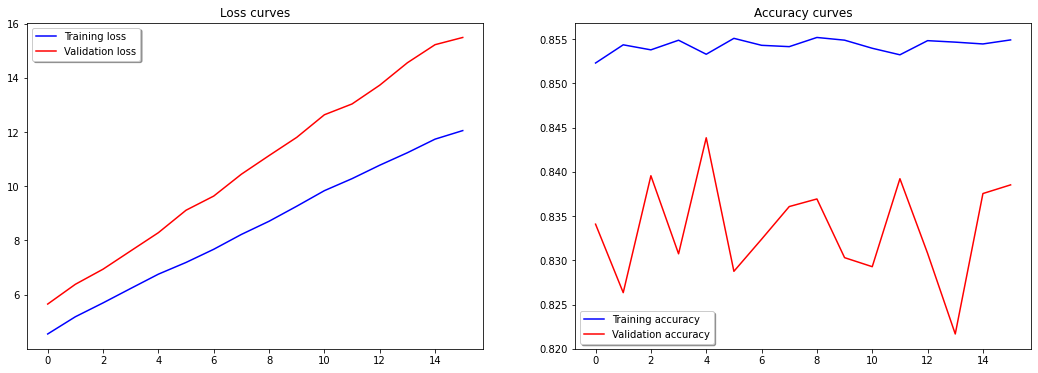

68/68 [==============================] - 7s 88ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'diag')
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm_bidir', 'lstm_bidir_diag.hdf5', 'lstm_bidir_diag')
del(X_train)
del(y_train)
del(X_test)
del(y_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 1000, 512)        550912    
 nal)                                                            
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 1000, 512)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 2,128,389
Trainable params: 2,128,389
No

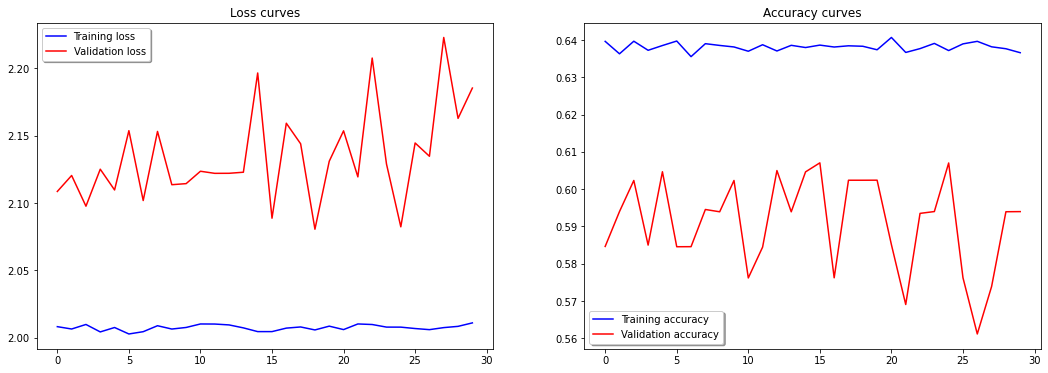

68/68 [==============================] - 7s 86ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'superdiag')
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm_bidir', 'lstm_bidir_superdiag.hdf5', 'lstm_bidir_superdiag')
del(X_train)
del(y_train)
del(X_test)
del(y_test)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 1000, 512)        550912    
 nal)                                                            
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 1000, 512)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 23)                11799     
                                                                 
Total params: 2,137,623
Trainable params: 2,137,623
No

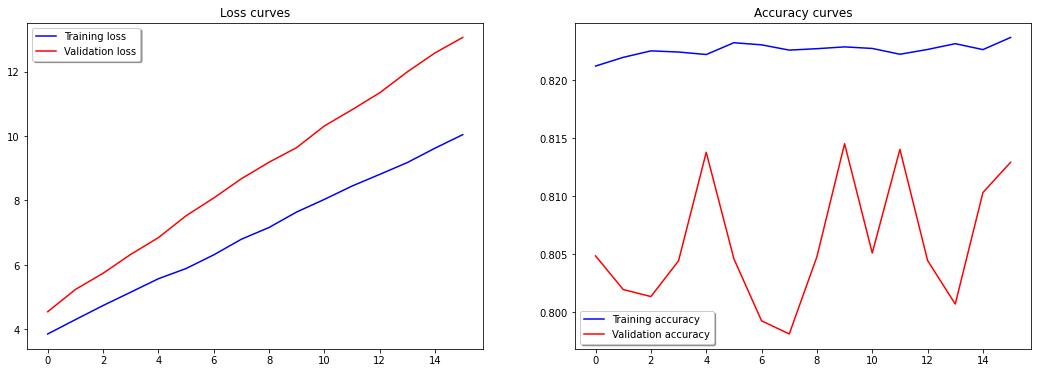

68/68 [==============================] - 7s 85ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'subdiag')
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm_bidir', 'lstm_bidir_subdiag.hdf5', 'lstm_bidir_subdiag')
del(X_train)
del(y_train)
del(X_test)
del(y_test)

In [ ]:
# X_train, y_train, X_test, y_test = load_ptbxl(task = 'rhythm')
# table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm_bidir', 'lstm_bidir_rhythm.hdf5', 'lstm_bidir_rhythm')
# del(X_train)
# del(y_train)
# del(X_test)
del(y_test)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 1000, 512)        550912    
 nal)                                                            
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 1000, 512)         0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 19)                9747      
                                                                 
Total params: 2,135,571
Trainable params: 2,135,571
No

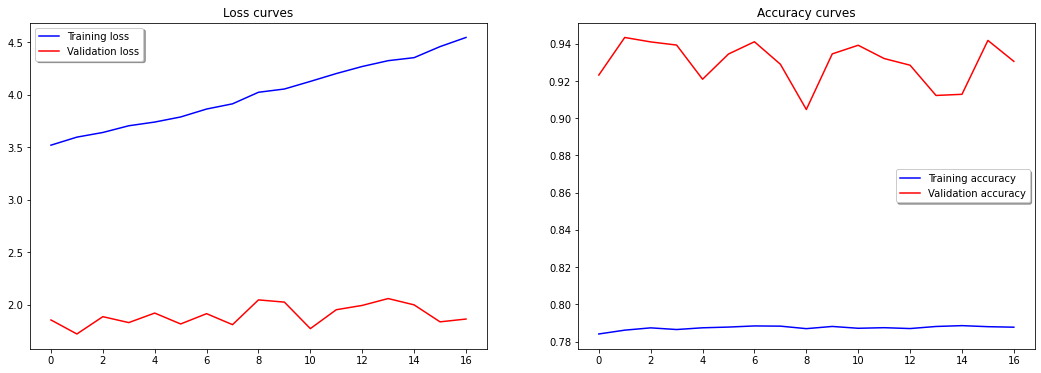

28/28 [==============================] - 4s 88ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train, y_train, X_test, y_test = load_ptbxl(task = 'form')
table_res_ptbxl = type_comp_fit_save_model_score(table_res_ptbxl, X_train, y_train, X_test, y_test, 'lstm_bidir', 'lstm_bidir_form.hdf5', 'lstm_bidir_form')
del(X_train)
del(y_train)
del(X_test)
del(y_test)

### Сохранение результатов в формате .csv

In [ ]:
table_res_ptbxl.to_csv('table_res_ptbxl.csv')